# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train_p2.p'
testing_file = 'test_p2.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = max(y_train)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

('Number of training examples =', 39209)
('Number of testing examples =', 12630)
('Image data shape =', (32, 32, 3))
('Number of classes =', 42)


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

In [5]:
'''
from https://github.com/vxy10/ImageAugmentation
'''

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    print("bright: ",random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img,ang_range,shear_range,trans_range,brightness=0):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    # Brightness

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    if brightness == 1:
        img = augment_brightness_camera_images(img)

    return img

def set_and_transform(input_data):
    output_data = []
    for image in input_data:
        output_data.append(transform_image(image,15,7,13,brightness=0))
    return output_data

def split_train_val_data(x_data, y_data, num_samples = 40):
    train_images = []
    val_images = []
    train_labels = []
    val_labels = []
    
    for lc in range(max(y_data)+1):
        id_class = [x for x in range(len(y_data)) if y_data[x] == lc]
        ids = random.sample(xrange(len(id_class)), num_samples)
        for k in range(len(id_class)):
            if k in ids:
                val_images.append(x_data[id_class[k]])
                val_labels.append(y_data[id_class[k]])
            else:
                train_images.append(x_data[id_class[k]])
                train_labels.append(y_data[id_class[k]])
    return train_images, train_labels, val_images, val_labels

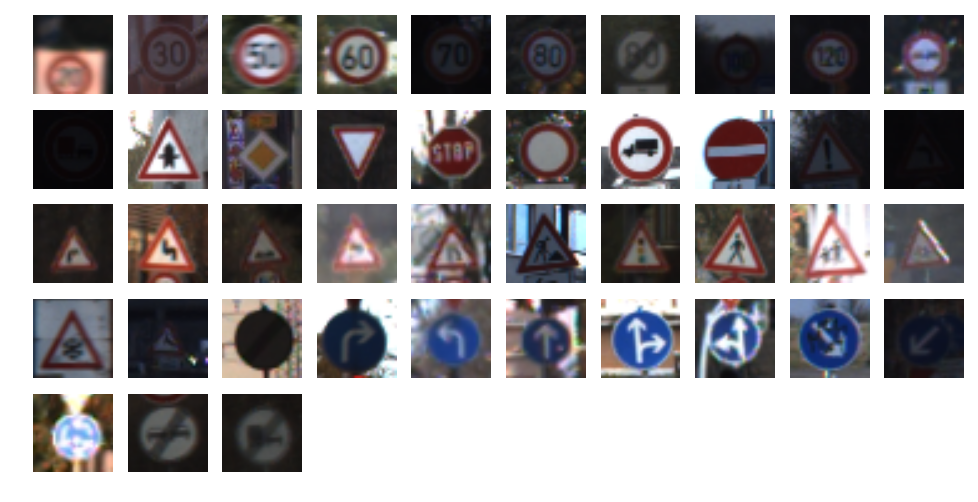

In [6]:
#show one image from each class of the dataset
gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes.
plt.figure(figsize=(12,12))


for i in range(43):
    id_class = i
    ids = y_train == id_class
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img_no_transform = random.choice(X_train[ids])
    #img = transform_image(img_no_transform,14,5,12,brightness=0)

    plt.subplot(10,10,i+1)
    plt.imshow(img_no_transform)
    plt.axis('off')
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
import numpy as np
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Input, Embedding, LSTM, Dense, merge, Convolution2D, MaxPooling2D, Reshape, Flatten, Dropout
from keras.optimizers import RMSprop, Adam
from keras import initializations

Using TensorFlow backend.


In [7]:
# Util functions
def my_init(shape, name=None):
    return initializations.normal(shape, scale=0.01, name=name)

In [8]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

In [9]:
# precprocess
max_label = np.max(y_train)
X_tr, y_tr, X_val, y_val = split_train_val_data(X_train, y_train)

x_tr_data = X_tr - np.mean(X_tr)
y_tr_data = np.zeros(shape=(len(y_tr), max_label + 1))

x_test_data = X_test - np.mean(X_tr)
y_test_data = np.zeros(shape=(len(y_test), max_label + 1))

x_val_data = X_val - np.mean(X_tr)
y_val_data = np.zeros(shape=(len(y_val), max_label + 1))

for i in range(len(y_tr)):
    y_tr_data[i, y_tr[i]]=1

for i in range(len(y_test)):
    y_test_data[i, y_test[i]]=1

for i in range(len(y_val)):
    y_val_data[i, y_val[i]]=1

print("shape information")
print(x_tr_data.shape)
print(x_val_data.shape)
print(x_test_data.shape)

shape information
(37489, 32, 32, 3)
(1720, 32, 32, 3)
(12630, 32, 32, 3)


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** I subtracted the mean of all pixels of the dataset. I chose this technique to center the  data

In [10]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

In [11]:
# select data
new_random_data = set_and_transform(X_tr)
x_train_data = np.vstack([X_tr, new_random_data])
x_train_data = x_train_data.astype(np.float64)
train_mean = np.mean(x_train_data)
x_train_data -= (train_mean)

y_train_data = np.vstack([y_tr_data, y_tr_data])

In [12]:
print(x_tr_data.shape)
print(x_train_data.shape)
print(y_train_data.shape)
print(x_val_data.shape)

(37489, 32, 32, 3)
(74978, 32, 32, 3)
(74978, 43)
(1720, 32, 32, 3)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** Training set: I generated new data using transformations such as, rotation, shear and translation. I added this new data in order to give more variability to the original dataset. The new dataset contains the original dataset, but with more samples applying the previous transformations. 

Validation set: I took 40 samples images from each class of the German dataset. 

Testing set: I used the orginal testing set from the German dataset

In [13]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [14]:
# network
# model few layers
main_input = Input(shape=(32, 32, 3), name='main_input')

conv1 = Convolution2D(64, 5, 5, init=my_init, border_mode='valid')(main_input)
conv2 = Convolution2D(128, 3, 3, init=my_init, border_mode='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Convolution2D(128, 3, 3, init=my_init, border_mode='same')(pool1)
conv4 = Convolution2D(128, 3, 3, init=my_init, border_mode='same')(conv3)

flat1 = Flatten()(conv4)

softmax_layer = Dense(43)(flat1)
main_output = Activation('softmax')(softmax_layer)

In [15]:
# model more layers
m_in = Input(shape=(32, 32, 3), name='m_in')

cn1 = Convolution2D(64, 5, 5, init=my_init, border_mode='valid')(m_in)
cn2 = Convolution2D(128, 3, 3, init=my_init, border_mode='same')(cn1)
pl1 = MaxPooling2D(pool_size=(2, 2))(cn2)

cn3 = Convolution2D(64, 3, 3, init=my_init, border_mode='same')(pl1)
cn4 = Convolution2D(256, 3, 3, init=my_init, border_mode='same')(cn3)
cn5 = Convolution2D(256, 3, 3, init=my_init, border_mode='same')(cn4)

flat_layer1 = Flatten()(cn5)

sm = Dense(43)(flat_layer1)
m_out = Activation('softmax')(sm)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** I created two models:
 * First model: <br>
1 conv layer with a kernel size of 5x5 and 64 channels <br>
1 conv layer with a kernel size of 3x3 and 128 channels <br>
1 pool layer with a kernel size of 2x2 <br>
2 conv layers with a kernel size of 3x3 and 128 channels <br>
1 flat layer
softmax layer

 * Second model: <br>
1 conv layer with a kernel size of 5x5 and 64 channels <br>
1 conv layer with a kernel size of 5x5 and 128 channels <br>
1 pool layer with a kernel size of 2x2 <br>
1 conv layer with a kernel size of 3x3 and 128 channels <br>
2 conv layers with a kernel size of 3x3 and 256 channels <br>
1 flat layer <br>
softmax layer

In [16]:
### Train your model here.
### Feel free to use as many code cells as needed.
print(np.sum(y_tr_data[:,5]))

1820.0


In [17]:
##### select inputs, outputs and customized sgd
sgd_select = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

fl_model = Model(input = [main_input], output = [main_output])
fl_model.compile(optimizer = sgd_select, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [22]:
model_path ='fl_model_original.h5'
fl_model.fit(x_tr_data, y_tr_data, shuffle=True, batch_size=16, verbose=2, nb_epoch=17)
fl_model.save(model_path)

Epoch 1/17
173s - loss: 0.5514 - acc: 0.8684
Epoch 2/17
164s - loss: 0.2236 - acc: 0.9530
Epoch 3/17
158s - loss: 0.1461 - acc: 0.9686
Epoch 4/17
158s - loss: 0.1287 - acc: 0.9742
Epoch 5/17
158s - loss: 0.1209 - acc: 0.9768
Epoch 6/17
158s - loss: 0.1063 - acc: 0.9800
Epoch 7/17
158s - loss: 0.1138 - acc: 0.9796
Epoch 8/17
158s - loss: 0.1127 - acc: 0.9814
Epoch 9/17
158s - loss: 0.1102 - acc: 0.9835
Epoch 10/17
159s - loss: 0.1524 - acc: 0.9819
Epoch 11/17
158s - loss: 0.1733 - acc: 0.9816
Epoch 12/17
158s - loss: 0.1719 - acc: 0.9830
Epoch 13/17
158s - loss: 0.2293 - acc: 0.9792
Epoch 14/17
158s - loss: 0.2021 - acc: 0.9831
Epoch 15/17
158s - loss: 0.3033 - acc: 0.9768
Epoch 16/17
158s - loss: 0.2984 - acc: 0.9780
Epoch 17/17
158s - loss: 0.3722 - acc: 0.9736


In [22]:
x_val_data = X_val - np.mean(X_tr)
model_path ='fl_model_original.h5'
fl_model.load_weights(model_path)
scores = fl_model.evaluate(x_val_data, y_val_data)
print("%s: %.2f%%" % (fl_model.metrics_names[1], scores[1]*100))

1720/1720 [==============================] - 9s       

In [18]:
model_path ='fl_model_new.h5'
fl_model.fit(x_train_data, y_train_data,shuffle=True, batch_size=16, verbose=2, nb_epoch=28)
fl_model.save(model_path)

Epoch 1/28
334s - loss: 1.6077 - acc: 0.5812
Epoch 2/28
320s - loss: 1.1455 - acc: 0.6923
Epoch 3/28
319s - loss: 1.0000 - acc: 0.7279
Epoch 4/28
325s - loss: 0.9053 - acc: 0.7514
Epoch 5/28
326s - loss: 0.8312 - acc: 0.7692
Epoch 6/28
324s - loss: 0.7746 - acc: 0.7841
Epoch 7/28
374s - loss: 0.7224 - acc: 0.7989
Epoch 8/28
419s - loss: 0.6830 - acc: 0.8085
Epoch 9/28
423s - loss: 0.6501 - acc: 0.8179
Epoch 10/28
437s - loss: 0.6231 - acc: 0.8246
Epoch 11/28
444s - loss: 0.5932 - acc: 0.8317
Epoch 12/28
363s - loss: 0.5704 - acc: 0.8404
Epoch 13/28
325s - loss: 0.5549 - acc: 0.8451
Epoch 14/28
326s - loss: 0.5422 - acc: 0.8495
Epoch 15/28
331s - loss: 0.5236 - acc: 0.8550
Epoch 16/28
326s - loss: 0.5194 - acc: 0.8573
Epoch 17/28
327s - loss: 0.4972 - acc: 0.8631
Epoch 18/28
327s - loss: 0.4906 - acc: 0.8650
Epoch 19/28
330s - loss: 0.4844 - acc: 0.8694
Epoch 20/28
331s - loss: 0.4705 - acc: 0.8735
Epoch 21/28
330s - loss: 0.4685 - acc: 0.8745
Epoch 22/28
325s - loss: 0.4634 - acc: 0.87

In [19]:
x_val_data = X_val - train_mean
scores = fl_model.evaluate(x_val_data, y_val_data)
print("%s: %.2f%%" % (fl_model.metrics_names[1], scores[1]*100))

1720/1720 [==============================] - 2s      

In [18]:
# select inputs, outputs and customized sgd
sgd_select = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ml_model = Model(input = [m_in], output = [m_out])
ml_model.compile(optimizer = sgd_select, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [24]:
model_path ='ml_model_original.h5'
ml_model.fit(x_tr_data, y_tr_data,shuffle=True, batch_size=16, verbose=2, nb_epoch=17)
ml_model.save(model_path)

Epoch 1/17
288s - loss: 0.5729 - acc: 0.8639
Epoch 2/17
286s - loss: 0.2494 - acc: 0.9456
Epoch 3/17
287s - loss: 0.1809 - acc: 0.9620
Epoch 4/17
290s - loss: 0.1618 - acc: 0.9675
Epoch 5/17
288s - loss: 0.1405 - acc: 0.9717
Epoch 6/17
288s - loss: 0.1328 - acc: 0.9738
Epoch 7/17
289s - loss: 0.1303 - acc: 0.9770
Epoch 8/17
290s - loss: 0.1168 - acc: 0.9792
Epoch 9/17
289s - loss: 0.1224 - acc: 0.9800
Epoch 10/17
295s - loss: 0.1459 - acc: 0.9782
Epoch 11/17
287s - loss: 0.1466 - acc: 0.9796
Epoch 12/17
285s - loss: 0.1856 - acc: 0.9780
Epoch 13/17
285s - loss: 0.2285 - acc: 0.9761
Epoch 14/17
285s - loss: 0.2792 - acc: 0.9751
Epoch 15/17
287s - loss: 0.3654 - acc: 0.9716
Epoch 16/17
288s - loss: 0.4287 - acc: 0.9691
Epoch 17/17
287s - loss: 0.5928 - acc: 0.9595


In [25]:
x_val_data = X_val - np.mean(X_tr)
scores = ml_model.evaluate(x_val_data, y_val_data)
print("%s: %.2f%%" % (ml_model.metrics_names[1], scores[1]*100))

1720/1720 [==============================] - 3s      

In [ ]:
model_path ='ml_model_new.h5'
ml_model.fit(x_train_data, y_train_data,shuffle=True, batch_size=16, verbose=2, nb_epoch=30)
ml_model.save(model_path)

Epoch 1/30
654s - loss: 2.2461 - acc: 0.4104
Epoch 2/30
717s - loss: 1.6893 - acc: 0.5622
Epoch 3/30
674s - loss: 1.3883 - acc: 0.6336
Epoch 4/30
579s - loss: 1.2466 - acc: 0.6673
Epoch 5/30
574s - loss: 1.1519 - acc: 0.6911
Epoch 6/30
574s - loss: 1.0924 - acc: 0.7064
Epoch 7/30
572s - loss: 1.0433 - acc: 0.7190
Epoch 8/30
570s - loss: 0.9999 - acc: 0.7285
Epoch 9/30
569s - loss: 0.9576 - acc: 0.7387
Epoch 10/30
569s - loss: 0.9234 - acc: 0.7468
Epoch 11/30
569s - loss: 0.8897 - acc: 0.7549
Epoch 12/30
569s - loss: 0.8627 - acc: 0.7612
Epoch 13/30
569s - loss: 0.8393 - acc: 0.7670
Epoch 14/30
569s - loss: 0.8174 - acc: 0.7722
Epoch 15/30
569s - loss: 0.7952 - acc: 0.7792
Epoch 16/30
569s - loss: 0.7731 - acc: 0.7837
Epoch 17/30
568s - loss: 0.7514 - acc: 0.7889
Epoch 18/30
569s - loss: 0.7295 - acc: 0.7932
Epoch 19/30
570s - loss: 0.7056 - acc: 0.8003
Epoch 20/30
571s - loss: 0.6842 - acc: 0.8058
Epoch 21/30
568s - loss: 0.6679 - acc: 0.8098
Epoch 22/30
570s - loss: 0.6470 - acc: 0.81

In [ ]:
x_val_data = X_val - train_mean
scores = fl_model.evaluate(x_val_data, y_val_data)
print("%s: %.2f%%" % (ml_model.metrics_names[1], scores[1]*100))

In [21]:
# check test performance
check_test = True
list_models = ['fl_model_original.h5',
               'fl_model_new.h5',
               'ml_model_original.h5']
dict_models = {'fl_model_original.h5': fl_model, 
               'fl_model_new.h5': fl_model,
               'ml_model_original.h5': ml_model,
               'ml_model_new.h5': ml_model,}
print("Testing set results")

for model_path in list_models:
    print(model_path)
    xmodel = dict_models[model_path]
    xmodel.load_weights(model_path)
    scores = xmodel.evaluate(x_test_data, y_test_data, verbose=2)
    print("%s: %.2f%%" % (xmodel.metrics_names[1], scores[1]*100))

Testing set results
fl_model_original.h5
acc: 87.96%
fl_model_new.h5
acc: 86.50%
ml_model_original.h5
acc: 89.52%


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** 
* Optimizer: Adam 
* Batch size: I used a batch size of 16 in order to fit my input data in the gpu memory (Nvidia GeForce 840M)
* Epochs: I used 17 epochs for models trained with the original dataset. Using the new generated data I used 28 epochs.
* Learning rate: I fixed the learning rate to 0.0001. To set this value, I first trained with a small set of 100 samples and see If the network converges with that value. 



### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:** I based my network in Vivek Yadav network from this link https://medium.com/@vivek.yadav/improved-performance-of-deep-learning-neural-network-models-on-traffic-sign-classification-using-6355346da2dc#.gq01dnpuj

I did some changes to my model due to my small gpu. First, I removed all fully connected layers in order to avoid too many parameters in the network. Thus, my model can be loaded in the gpu. Second, the first conv layer resize the feature map to 28x28 (the original size of the dataset) and add more channels to the output. I added more channels to the outputs of the conv layers in order to give the network more complexity. I keep spatial information across the layers and use it in the softmax layer.

I created two networks to see a difference in improvement. The second network has more layers than the first one and has better performance on the testing set. Moreover, I was expecting to have better performance training with data augmentation, but I could not converge the network in the learning process.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

In [27]:
def load_image(image_path):
    mat_im = cv2.imread(image_path)
    mat_im = cv2.resize(mat_im,(32,32))
    mat_im = cv2.cvtColor(mat_im, cv2.COLOR_BGR2RGB)
    return mat_im

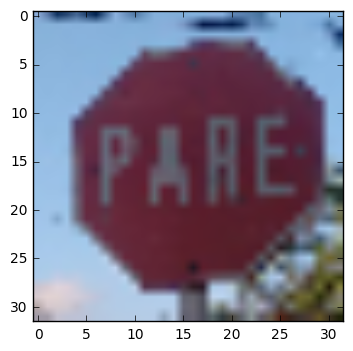

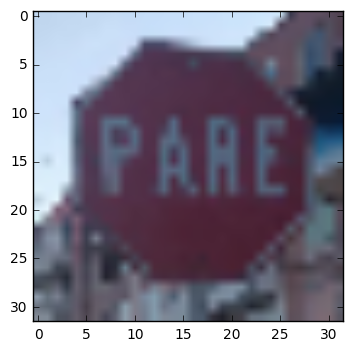

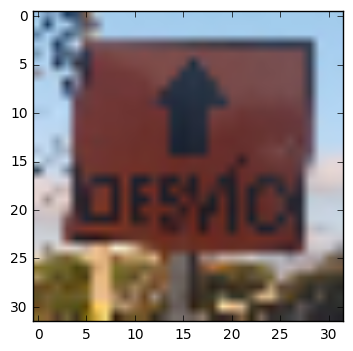

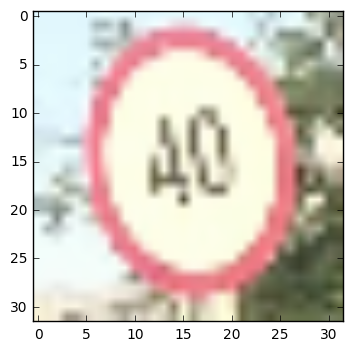

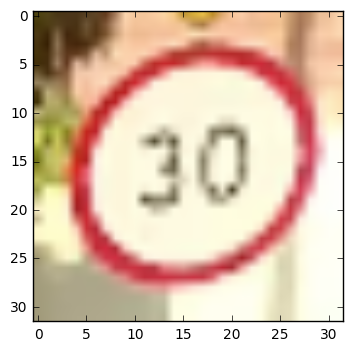

In [28]:
list_files = ['imbaq0.jpg', 
              'imbaq1.jpg', 
              'imbaq2.jpg', 
              'imbaq3.png', 
              'imbaq4.png']

colombian_images = np.zeros(shape=(5,32,32,3))
k = 0
for im_path in list_files:
    im_traffic = load_image(im_path)
    colombian_images[k] = im_traffic
    plt.figure()
    plt.imshow(im_traffic)
    k += 1

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:** The images contain some words in spanish. That feature can be confusing for the network because is not trained with them. In addition, some images belong to classes which are not in the German dataset

In [29]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

In [30]:
import csv
with open('signnames.csv', mode='r') as infile:
    reader = csv.reader(infile)
    with open('coors_new.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        mydict = {rows[0]:rows[1] for rows in reader}

In [31]:
model_path ='ml_model_original.h5'
ml_model.load_weights(model_path)
preds = ml_model.predict(colombian_images)
class_preds = np.argmax(preds,1)
print(class_preds)
for k in range(len(class_preds)):
    print(class_preds[k],mydict[str(class_preds[k])])

[14 14 14 23  1]
(14, 'Stop')
(14, 'Stop')
(14, 'Stop')
(23, 'Slippery road')
(1, 'Speed limit (30km/h)')


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:** the model predicted 3 out of 5 signs correctly, which it's 60% accurate (PARE = STOP). Taking into account that some images do not have the same classes of the german dataset, it is providing accurate predictions.

In [32]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

In [33]:
top_k = 3
for k in range(len(class_preds)):
    sorted_class = np.argsort(preds[k])[::-1]
    #for j in range(sorted_clas)
    for j in range(top_k):
        print("image", k, mydict[str(sorted_class[j])],"probability", preds[k, sorted_class[j]])

('image', 0, 'Stop', 'probability', 1.0)
('image', 0, 'No entry', 'probability', 9.6762155e-33)
('image', 0, 'End of no passing by vehicles over 3.5 metric tons', 'probability', 0.0)
('image', 1, 'Stop', 'probability', 1.0)
('image', 1, 'Right-of-way at the next intersection', 'probability', 1.0235599e-19)
('image', 1, 'End of no passing by vehicles over 3.5 metric tons', 'probability', 0.0)
('image', 2, 'Stop', 'probability', 1.0)
('image', 2, 'Double curve', 'probability', 4.5302345e-28)
('image', 2, 'No passing for vehicles over 3.5 metric tons', 'probability', 0.0)
('image', 3, 'Slippery road', 'probability', 0.99941611)
('image', 3, 'Speed limit (100km/h)', 'probability', 0.00058386807)
('image', 3, 'Speed limit (80km/h)', 'probability', 2.2635589e-33)
('image', 4, 'Speed limit (30km/h)', 'probability', 1.0)
('image', 4, 'End of no passing by vehicles over 3.5 metric tons', 'probability', 0.0)
('image', 4, 'No passing for vehicles over 3.5 metric tons', 'probability', 0.0)


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:** The model is certainy of its predictions, because the probabilities are close to 1. Even if the images are not from the dataset, it is predicting well for stop images.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.